## Исходные данные

In [1]:
import pandas as pd

In [2]:
csv_file_path = r'..\Dataset\Workorder.csv'

data_frame = pd.read_csv(csv_file_path, delimiter=',', encoding='utf-8')

In [354]:
num_rows = data_frame.shape[0]
num_rows

107700

In [10]:
data_frame.columns.tolist()

['workorderid',
 'queuename',
 'requesttypedefinition_name',
 'title',
 'description',
 'resolution',
 'servicedefinition_name',
 'categoryname',
 'subcategorydefinition_name',
 'text_description',
 'text_resolution']

## html to text

In [3]:
from bs4 import BeautifulSoup

In [4]:
def get_text(html):
    if isinstance(html, float):
        return ''
    soup = BeautifulSoup(html, 'html.parser')
    text = soup.get_text()
    return text

In [5]:
for index, row in data_frame.iterrows():
    
    description = row['description']
    resolution = row['resolution']
    
    text_description = get_text(description)
    text_resolution = get_text(resolution)
    
    data_frame.at[index, 'text_description'] = text_description
    data_frame.at[index, 'text_resolution'] = text_resolution

C:\Users\a.makey\AppData\Local\Temp\ipykernel_6204\3272438639.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(html, 'html.parser')
C:\Users\a.makey\AppData\Local\Temp\ipykernel_6204\3272438639.py:4: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(html, 'html.parser')


## Функции для обработки текста

In [6]:
import re
from collections import defaultdict

In [326]:
with open(r'Данные\END_OF_SENT.json', 'r') as f:
    END_OF_SENT = json.load(f)

# Функция удаления лишнего в конце запроса
def delete_ends(description_list):
    ends_description_list = []
    for i, sentence in enumerate(description_list):
        end_found = False

        for ends in END_OF_SENT:

            if ends in sentence:
                end_found = True
                end_index = sentence.rfind(ends)
                ends_description_list.append(sentence[:end_index])
                break

        if not end_found:
            ends_description_list.append(sentence)
            
    return ends_description_list

In [7]:
def filter_text(text):
    
    filtered_text = text.lower()
    filtered_text = filtered_text.strip()
    
    # Удаление символов '\xa0' и '\n'
    for item in ['\xa0',r'\n']: 
        filtered_text = filtered_text.replace(item, '')
    
    # Удаление всех символов, кроме букв, пробелов и знаков препинания, относящихся к окончанию предложения
    filtered_text = re.sub(r'[^А-Яа-яA-Za-zЁё\s\.\?!]', '', filtered_text)
    # Добавление пробелов слева и справа от знаков препинания, относящихся к окончанию предложения
    filtered_text = re.sub(r'\s*([.?!])\s*', r' \1 ', filtered_text)
    # Замена множественных пробелов на одиночные пробелы
    filtered_text = re.sub(r'\s+', ' ', filtered_text)
    
    return filtered_text, filtered_text.split()

## Признаки
- Группа
- Тип запроса
- Категория услуги
- Категория
- Подкатегория

In [19]:
def get_dict_labels(list_labels):
    dict_labels = defaultdict(int)
    for label in list_labels:
        dict_labels[label] += 1
    return dict_labels, {class_: index for index, class_ in enumerate(list(dict_labels.keys()))}

In [22]:
# Группа
list_1_labels = [str(row['queuename']) for index, row in data_frame.iterrows()]
_, label_1_to_key = get_dict_labels(list_1_labels)
index_1_labels = [label_1_to_key[label] for label in list_1_labels]
NUM_1_CLASSES = len(label_1_to_key)

In [27]:
# Тип запроса
list_2_labels = [str(row['requesttypedefinition_name']) for index, row in data_frame.iterrows()]
_, label_2_to_key = get_dict_labels(list_2_labels)
index_2_labels = [label_2_to_key[label] for label in list_2_labels]
NUM_2_CLASSES = len(label_2_to_key)

In [29]:
# Категория услуги
list_3_labels = [str(row['servicedefinition_name']) for index, row in data_frame.iterrows()]
_, label_3_to_key = get_dict_labels(list_3_labels)
index_3_labels = [label_3_to_key[label] for label in list_3_labels]
NUM_3_CLASSES = len(label_3_to_key)

In [30]:
# Категория
list_4_labels = [str(row['categoryname']) for index, row in data_frame.iterrows()]
_, label_4_to_key = get_dict_labels(list_4_labels)
index_4_labels = [label_4_to_key[label] for label in list_4_labels]
NUM_4_CLASSES = len(label_4_to_key)

In [31]:
# Подкатегория
list_5_labels = [str(row['subcategorydefinition_name']) for index, row in data_frame.iterrows()]
_, label_5_to_key = get_dict_labels(list_5_labels)
index_5_labels = [label_5_to_key[label] for label in list_5_labels]
NUM_5_CLASSES = len(label_5_to_key)

In [32]:
# Кол- во классов в каждом признаке
NUM_1_CLASSES, NUM_2_CLASSES, NUM_3_CLASSES, NUM_4_CLASSES, NUM_5_CLASSES

(3, 3, 23, 54, 459)

## Запрос или входная строка

In [327]:
description_list = [str(row['title']) + '. ' + str(row['text_description']) for index, row in data_frame.iterrows()]

description_list = delete_ends(description_list)

description_tokens = [filter_text(text)[1] for text in description_list]

### Анализ длины предложений

In [343]:
import matplotlib.pyplot as plt

In [341]:
description_lens = [len(row) for row in description_tokens]

In [342]:
# Создание словаря с подсчетом количества чисел
description_counts = {}
for number in description_lens:
    description_counts[number] = description_counts.get(number, 0) + 1
    
# Получение значений для осей X и Y
description_x = list(description_counts.keys())
description_y = list(description_counts.values())

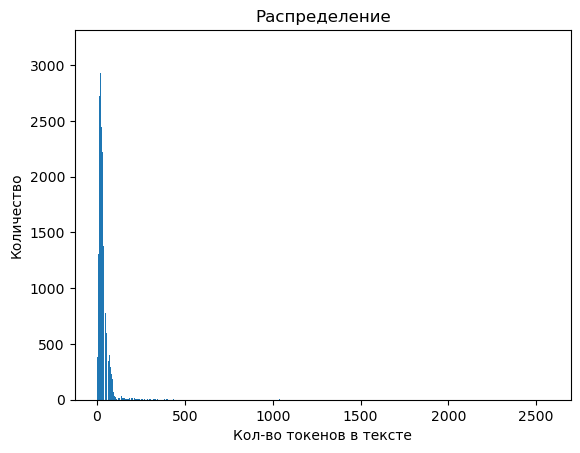

In [396]:
# Построение графика
plt.bar(description_x, description_y)

# Добавление подписей осей и заголовка
plt.xlabel('Кол-во токенов в тексте')
plt.ylabel('Количество')
plt.title('Распределение')

# Отображение графика
plt.show()

In [363]:
description_sorted_dict = dict(sorted(description_counts.items(), key=lambda x: x[0]))

share = 0.0
limit_share = 0.50
for item in description_sorted_dict.keys():
    share += description_sorted_dict[item]/num_rows
    if share>=limit_share:
        description_max_len = item
        break
description_max_len

26

Для 50% запросов кол-во токенов 26. Будем ограничивать запрос 26 токенами

In [380]:
description_tokens_short = [token[:description_max_len] for token in description_tokens]

## Решение или выходная строка

In [38]:
resolution_list = [str(row['text_resolution']) for index, row in data_frame.iterrows()]

resolution_tokens = [filter_text(text)[1] for text in resolution_list]

## Анализ длины предложений

In [364]:
resolution_lens = [len(row) for row in resolution_tokens]

In [365]:
# Создание словаря с подсчетом количества чисел
resolution_counts = {}
for number in resolution_lens:
    resolution_counts[number] = resolution_counts.get(number, 0) + 1
    
# Получение значений для осей X и Y
resolution_x = list(resolution_counts.keys())
resolution_y = list(resolution_counts.values())

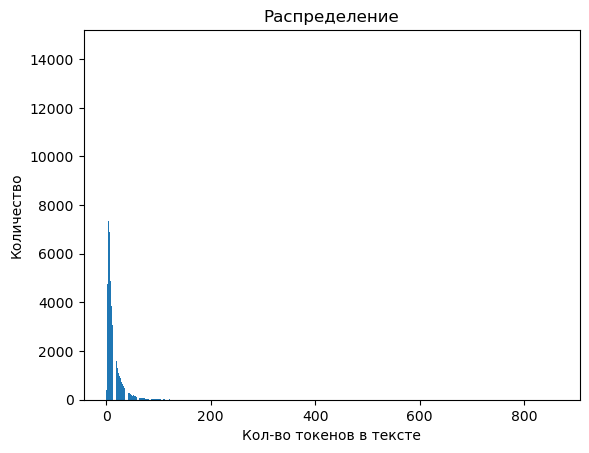

In [397]:
# Построение графика
plt.bar(resolution_x, resolution_y)

# Добавление подписей осей и заголовка
plt.xlabel('Кол-во токенов в тексте')
plt.ylabel('Количество')
plt.title('Распределение')

# Отображение графика
plt.show()

In [368]:
resolution_sorted_dict = dict(sorted(resolution_counts.items(), key=lambda x: x[0]))

share = 0.0
limit_share = 0.90
for item in resolution_sorted_dict.keys():
    share += resolution_sorted_dict[item]/num_rows
    if share>=limit_share:
        resolution_max_len = item
        break
resolution_max_len

31

Для 90% ответов кол-во токенов 31. Будем ограничивать ответ 31 токенами

In [381]:
resolution_tokens_short = [token[:resolution_max_len] for token in resolution_tokens]

## Функция создания словаря

In [369]:
def build_dictionary(seqs_tokens, existing_dictionary=None, max_len=None):
    
    # Создание нового словаря или использование существующего
    dictionary = existing_dictionary if existing_dictionary is not None else defaultdict(int)
    dictionary["[NULL]"] = 0
    
    for tokens in seqs_tokens:
        if not max_len:
            max_len = len(tokens)
        for token in tokens[:max_len]:
            dictionary[token] += 1
    return dictionary

## Словарь

In [382]:
dictionary = build_dictionary(description_tokens_short)

dictionary = build_dictionary(resolution_tokens_short, dictionary)

In [383]:
dictionary_len = len(dictionary)

# Токенов в словаре
dictionary_len

96101

## Удаляем токены из словаря, которые встречаются один раз
- Делаем это чтобы уменьшить объем словаря и в последствии уменьшим кол-во параметров в модели

In [384]:
keys_to_remove = []

for key, value in dictionary.items():
    if value == 1:
        keys_to_remove.append(key)

In [385]:
for key in keys_to_remove:
    dictionary.pop(key)

In [386]:
dictionary_len = len(dictionary)

# Токенов в словаре
dictionary_len

45219

## Токены в индексы

In [375]:
token_to_index = {token: index for index, token in enumerate(list(dictionary.keys()))}

Вот тут
`if token in token_to_index`
пропускаем те токены, которых нет в словаре

In [387]:
description_indexes = [[token_to_index[token] for token in sentence if token in token_to_index] 
                     for sentence in description_tokens_short]

In [388]:
resolution_indexes = [[token_to_index[token] for token in sentence if token in token_to_index] 
                     for sentence in resolution_tokens_short]

## Пример того как это выглядит

In [392]:
## Входные данные
print(description_indexes[10])

[128, 129, 130, 131, 2, 6, 106, 132, 133, 134, 135, 131, 136, 137, 138, 139, 140, 18, 39, 141, 142, 143, 144, 15, 145]


In [393]:
## Выходные данные
print(resolution_indexes[10])

[75, 974, 714, 39, 792, 2]


In [394]:
## Признаки
print(index_1_labels[10], index_2_labels[10], index_3_labels[10], index_4_labels[10], index_5_labels[10])

1 1 2 6 10


## Сохранение данных

In [395]:
import json

# Входные данные
with open(r'Данные\description_indexes.json', 'w') as f:
    json.dump(description_indexes, f, indent=4)

# Выходные данные
with open(r'Данные\resolution_indexes.json', 'w') as f:
    json.dump(resolution_indexes, f, indent=4)

# Словарь для входных и выходных данных
with open(r'Данные\dictionary.json', 'w') as f:
    json.dump(dictionary, f, indent=4)
    
## Признаки и соответствующие словари
with open(r'Данные\index_1_labels.json', 'w') as f:
    json.dump(index_1_labels, f, indent=4)
with open(r'Данные\label_1_to_key.json', 'w') as f:
    json.dump(label_1_to_key, f, indent=4)

with open(r'Данные\index_2_labels.json', 'w') as f:
    json.dump(index_2_labels, f, indent=4)
with open(r'Данные\label_2_to_key.json', 'w') as f:
    json.dump(label_2_to_key, f, indent=4)

with open(r'Данные\index_3_labels.json', 'w') as f:
    json.dump(index_3_labels, f, indent=4)
with open(r'Данные\label_3_to_key.json', 'w') as f:
    json.dump(label_3_to_key, f, indent=4) 

with open(r'Данные\index_4_labels.json', 'w') as f:
    json.dump(index_4_labels, f, indent=4)
with open(r'Данные\label_4_to_key.json', 'w') as f:
    json.dump(label_4_to_key, f, indent=4) 

with open(r'Данные\index_5_labels.json', 'w') as f:
    json.dump(index_5_labels, f, indent=4)
with open(r'Данные\label_5_to_key.json', 'w') as f:
    json.dump(label_5_to_key, f, indent=4) 